# Movimiento Browniano

Paquetes necesarios.

In [2]:
import numpy as np
from random import random
import tqdm
from matplotlib import pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from scipy.stats import linregress as lr
from scipy import zeros, random, stats, std, sqrt, log, arange
import warnings
warnings.filterwarnings("ignore")

Las siguientes variables son definidas para la simulación de los diferentes movimientos brownianos. 

* $N$ es el número de subintervalos.
* $dt$ es el tamaño del incremento.
* $k$ es el número de trayectorias.
* $t$ es el vector de tiempo

In [3]:
N = 1000
dt = 1/N
k = 100
t = np.arange(0, 1, dt)

Generamos $k$ trayectorias para el movimiento browniano estándar.

In [4]:
B = np.zeros((k, N))
for i in range(k):
    for j in range(1, N):
        B[i,j] = B[i, j-1] + np.sqrt(dt)*np.random.normal()

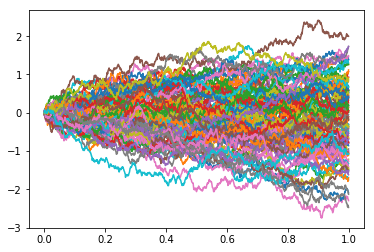

In [5]:
for i in range(k):
    plt.plot(t, B[i])
plt.show()

Generamos $k$ trayectorias para el movimiento Browniano Bridge

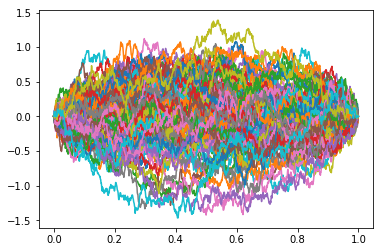

In [6]:
BB = np.zeros((k, N))
for i in range(k):
    for j in range(N):
        BB[i,j] = B[i, j] - t[j]*B[i, N-1]
for i in range(k):
    plt.plot(t, BB[i])
plt.show()

#### Análisis vertical
Dadas las propiedades del movimiento browniano, un análisis vertical de cualquier punto de su trayectoria debe resultar en una variable aleatoria con distribución normal.

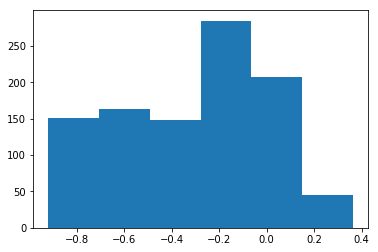

In [7]:
X = B[:][round(k/2)]
plt.hist(X, 6)
plt.show()

## Tests de normalidad

### Test de Jarque-Bera
El test de Jarque-Bera comprueba si los datos de la muestra tienen la asimetría y la curtosis que coinciden con una distribución normal.
El primer valor retornado por el método es el estadístico de prueba, el segundo el p-valor asociado a ella. 
* Un $p$-valor menor a 0.5 no rechaza la hipótesis nula de normalidad.
* Un $p$-valor superior a 0.5 rechaza la hipótesis nula de normalidad.

In [8]:
from scipy import stats
jb = stats.jarque_bera(X)

### Test de Lilliefors
Es una versión modificada del test de Kolmogorov-Smirnov que prueba la normalidad de un conjunto de datos. El primer valor retornado por el método es el estadístico de prueba, el segundo el p-valor asociado a ella.
* Un $p$-valor menor a 0.5 no rechaza la hipótesis nula de normalidad.
* Un $p$-valor superior a 0.5 rechaza la hipótesis nula de normalidad.

In [9]:
from statsmodels.stats.diagnostic import lilliefors
lilie = lilliefors(X)

### Test de Shapiro-Wilk
Prueba la hipótesis nula de que los datos se extrajeron de una distribución normal.
El primer valor retornado por el método es el estadístico de prueba, el segundo el p-valor asociado a ella.
* Un $p$-valor menor a 0.5 no rechaza la hipótesis nula de normalidad.
* Un $p$-valor superior a 0.5 rechaza la hipótesis nula de normalidad.


In [10]:
shapiro = stats.shapiro(X)

In [11]:
df = pd.DataFrame()
df['Jarque Bera'] = [1 if jb[1]<0.05 else 0]
df['Shapiro Wilks'] = [1 if shapiro[1]<0.05 else 0]
df['Lilliefors'] = [1 if lilie[1]<0.05 else 0]
df

,Jarque Bera,Shapiro Wilks,Lilliefors
0,1,1,1


## Coeficiente de Hurst

In [12]:
def hurst(signal):
    tau = []; lagvec = []

    #  Step through the different lags
    for lag in range(2,20):

    #  produce price difference with lag
        pp = np.subtract(signal[lag:],signal[:-lag])

    #  Write the different lags into a vector
        lagvec.append(lag)

    #  Calculate the variance of the difference vector
        tau.append(np.std(pp))

    #  linear fit to double-log graph (gives power)
    m = np.polyfit(np.log10(lagvec),np.log10(tau),1)

    # calculate hurst
    hurst = m[0]

    return hurst


In [13]:
hs = []
for i in range(k):
    hs.append(hurst(B[i]))

np.mean(hs)

0.4880856442447828

## Cálculo de la dimensión fractal de una serie de tiempo
Utilizando el algoritmo propuesto por Higuchi, 1988, en el artículo "Approach to an irregular time series on the basis of the fractal theory". La implementación del algoritmo puede ser encontrada aquí: <https://github.com/gilestrolab/pyrem/blob/master/src/pyrem/univariate.py>

In [14]:
def hFD(a, k_max): #Higuchi FD

    L = []
    x = []
    N = len(a)

    for k in range(1,k_max):
        Lk = 0
        for m in range(0,k):
            #we pregenerate all idxs
            idxs = np.arange(1,int(np.floor((N-m)/k)),dtype=np.int32)
            Lmk = np.sum(np.abs(a[m+idxs*k] - a[m+k*(idxs-1)]))
            Lmk = (Lmk*(N - 1)/(((N - m)/ k)* k)) / k
            Lk += Lmk

        L.append(np.log(Lk/(m+1)))
        x.append([np.log(1.0/ k), 1])

    (p, r1, r2, s)=np.linalg.lstsq(x, L)
    return p[0]

In [15]:
dfs = []
for i in range(k):
    dfs.append(hFD(B[i], 4))

np.mean(dfs)

1.5043106182249861

In [16]:
type(B[1])

numpy.ndarray